In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext nb_black
import tensorflow as tf
import math


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Strategy: Try baseline ML based on top 50 populated.
- GRU for top 50
- Baseline for other 50

In [118]:
county_data = pd.read_csv("../data/processed/county_data.csv")
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
timeseries = pd.read_csv("../data/processed/timeseries_15_rows_per_county.csv")

<IPython.core.display.Javascript object>

## Understand the data
Timeseries is our train dataset but for each cfip we have taken microdensity instances 1-23 and used 24 as target, 2-24, 25 target and so on

In [119]:
print(f"timeseries shape: {timeseries.shape}")
timeseries.head(20)

timeseries shape: (47025, 29)


,cfips,POPESTIMATE2021,active,target,target_date,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,1001,59095,1249,3.219917,2021-08-01,3.007682,2.884870,3.055843,2.993233,2.993233,...,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433
1,1001,59095,1249,3.186722,2021-09-01,2.884870,3.055843,2.993233,2.993233,2.969090,...,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917
2,1001,59095,1249,3.203320,2021-10-01,3.055843,2.993233,2.993233,2.969090,2.909326,...,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722
3,1001,59095,1249,3.200948,2021-11-01,2.993233,2.993233,2.969090,2.909326,2.933231,...,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320
4,1001,59095,1249,3.286307,2021-12-01,2.993233,2.969090,2.909326,2.933231,3.000167,...,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948
5,1001,59095,1249,3.296781,2022-01-01,2.969090,2.909326,2.933231,3.000167,3.004948,...,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307
6,1001,59095,1249,3.334431,2022-02-01,2.909326,2.933231,3.000167,3.004948,3.019292,...,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781
7,1001,59095,1249,3.336785,2022-03-01,2.933231,3.000167,3.004948,3.019292,3.083837,...,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431
8,1001,59095,1249,3.372082,2022-04-01,3.000167,3.004948,3.019292,3.083837,3.174679,...,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785
9,1001,59095,1249,3.313253,2022-05-01,3.004948,3.019292,3.083837,3.174679,3.205756,...,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785,3.372082


<IPython.core.display.Javascript object>

### Find 50% percentile population and store the cfips

In [120]:
latest_month = county_data[county_data["first_day_of_month"]==county_data["first_day_of_month"].max()]
print("len latrst month: ", len(latest_month))
cfips_largest_counties = latest_month[latest_month["POPESTIMATE2021"]>latest_month["POPESTIMATE2021"].quantile(.50)]["cfips"].values
print("Size of largest counties list: ", len(cfips_largest_counties))


len latrst month:  3135
Size of largest counties list:  1567


<IPython.core.display.Javascript object>

In [121]:
largest_counties = timeseries[timeseries["cfips"].isin(cfips_largest_counties)]
print("largest_df shape: ", largest_counties.shape)
print(f"smallest county is {largest_counties[largest_counties['POPESTIMATE2021']==largest_counties['POPESTIMATE2021'].min()]['cfips'].head(1).values} and size: {largest_counties['POPESTIMATE2021'].min()} ")


largest_df shape:  (23505, 29)
smallest county is [27015] and size: 25819 


<IPython.core.display.Javascript object>

In [122]:
#Smallest county dict maping cfips to target
latest_month_small = train[train["first_day_of_month"]== train["first_day_of_month"].max()]
latest_month_small.set_index("cfips", inplace=True)
smallest_pred = latest_month_small[~latest_month_small.index.isin(cfips_largest_counties)]["microbusiness_density"].to_dict()
len(smallest_pred)


1568

<IPython.core.display.Javascript object>

In [123]:
smallest_pred

{1005: 1.2320744,
 1007: 1.28724,
 1011: 0.98809224,
 1013: 2.1859705,
 1019: 1.117345,
 1023: 1.6851181,
 1025: 1.3526518,
 1027: 1.5829384,
 1029: 1.3555517,
 1035: 1.095947,
 1037: 0.82838911,
 1041: 1.0612549,
 1057: 1.0514109,
 1063: 1.4407436,
 1065: 1.1825964,
 1067: 2.4543042,
 1075: 0.93406087,
 1085: 1.4121,
 1087: 1.8822141,
 1091: 1.3613777,
 1099: 1.0884768,
 1105: 0.64111501,
 1107: 0.7700907,
 1111: 5.3465791,
 1119: 1.0226156,
 1129: 0.94889945,
 1131: 1.1442786,
 1133: 3.5551553,
 2013: 0.88255262,
 2016: 1.2577276,
 2050: 0.85920882,
 2060: 12.080537,
 2068: 13.96075,
 2070: 1.7099056,
 2100: 5.390995,
 2105: 4.951561,
 2130: 5.8247948,
 2150: 2.7874913,
 2164: 4.0697675,
 2180: 1.6190622,
 2185: 1.3205631,
 2188: 0.46333602,
 2195: 3.1261494,
 2198: 3.5217035,
 2220: 6.198102,
 2230: 6.4285712,
 2240: 4.0007882,
 2275: 5.4911838,
 2282: 4.5553145,
 2290: 2.9265742,
 4011: 1.3226744,
 4012: 2.2875261,
 5001: 1.7232567,
 5003: 1.0756869,
 5011: 0.98913175,
 5013: 0.357

<IPython.core.display.Javascript object>

## Deep Learning

In [124]:
def build_model():

    inp = tf.keras.Input(shape=(24, 1))
    x = tf.keras.layers.GRU(units=128, return_sequences=False)(inp)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32,activation='relu', kernel_initializer='glorot_uniform')(x)
    # x = tf.keras.layers.Dense(16,activation='relu', kernel_initializer='glorot_uniform')(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer=opt)

    return model

<IPython.core.display.Javascript object>

In [125]:
model = build_model()

<IPython.core.display.Javascript object>

In [126]:
model.summary()
LR_MAX = 0.001
LR_MIN = 1e-6 
EPOCHS = 70
BATCH_SIZE = 100

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 gru_3 (GRU)                 (None, 128)               50304     
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 54,465
Trainable params: 54,465
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

Learning rate schedule: 0.001 to 0.001 to 1e-06


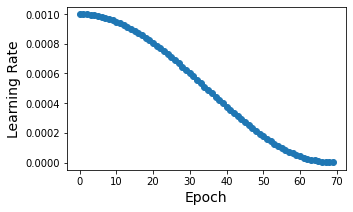

<IPython.core.display.Javascript object>

In [127]:
# a simple cosine learning rate without restart
def lrfn(epoch_i, EPOCHS):

    decay_total_epochs = EPOCHS - 1
    phase = math.pi * epoch_i / decay_total_epochs  # 0 ~ pi
    cosine_decay = 0.5 * (1 + math.cos(phase))
    lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x, EPOCHS) for x in rng]
plt.figure(figsize=(5, 3))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = 0)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [128]:
X_train = largest_counties.drop(
    ["target", "target_date", "cfips", "POPESTIMATE2021", "active"], axis=1
)
y_train = largest_counties["target"]

<IPython.core.display.Javascript object>

In [129]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
# train with gpu
result = None
with tf.device("/GPU:0"):
    # result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks = [LR])
    result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,)

Num GPUs Available:  1
Epoch 1/70
236/236 [==============================] - 4s 10ms/step - loss: 27.4399
Epoch 2/70
236/236 [==============================] - 2s 10ms/step - loss: 14.2397
Epoch 3/70
236/236 [==============================] - 2s 10ms/step - loss: 8.1769
Epoch 4/70
236/236 [==============================] - 2s 10ms/step - loss: 4.9555
Epoch 5/70
236/236 [==============================] - 2s 10ms/step - loss: 3.4579
Epoch 6/70
236/236 [==============================] - 2s 10ms/step - loss: 2.9847
Epoch 7/70
236/236 [==============================] - 2s 10ms/step - loss: 2.7127
Epoch 8/70
236/236 [==============================] - 2s 10ms/step - loss: 2.8404
Epoch 9/70
236/236 [==============================] - 2s 10ms/step - loss: 2.8241
Epoch 10/70
236/236 [==============================] - 2s 10ms/step - loss: 2.2437
Epoch 11/70
236/236 [==============================] - 2s 10ms/step - loss: 2.5066
Epoch 12/70
236/236 [==============================] - 2s 10ms/step - l

<IPython.core.display.Javascript object>

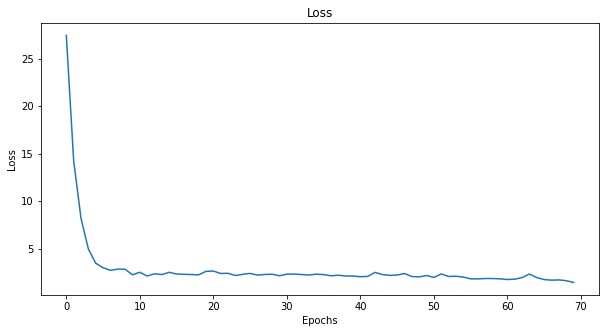

<IPython.core.display.Javascript object>

In [130]:
# plot the loss
fig = plt.figure(figsize=(10, 5))
plt.plot(result.history["loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [131]:

predictions = np.zeros((len(cfips_largest_counties), 8))
test_df = largest_counties[largest_counties["target_date"] == largest_counties["target_date"].max()].drop(
    ["target_date", "POPESTIMATE2021", "active", "cfips"], axis=1
)

<IPython.core.display.Javascript object>

## Predictions


In [132]:
test_df.head()

,target,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
14,3.463856,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,...,3.286307,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677
29,8.359798,8.329126,8.263252,8.224466,8.011045,7.909001,7.978031,8.032654,8.061466,8.077073,...,7.930010,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701
74,1.831783,1.641125,1.641125,1.613962,1.612029,1.688793,1.700081,1.702339,1.720401,1.713628,...,1.752009,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060
119,2.800514,2.906498,2.892038,2.883139,2.880691,2.702250,2.698905,2.689983,2.649834,2.642027,...,2.696674,2.701134,2.706717,2.717883,2.707833,2.691084,2.724583,2.782648,2.788231,2.809447
134,1.442544,1.379568,1.360925,1.338553,1.383719,1.282196,1.282196,1.293476,1.282196,1.252115,...,1.402519,1.412333,1.438767,1.457649,1.480307,1.487859,1.468978,1.548280,1.521846,1.502964


<IPython.core.display.Javascript object>

In [133]:
test_df[24] =test_df["target"]
test_df.drop(["target","0"], axis=1, inplace=True)
test_df.columns = range(0,24)
test_df.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
14,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
29,8.263252,8.224466,8.011045,7.909001,7.978031,8.032654,8.061466,8.077073,7.984033,7.918605,...,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798
74,1.641125,1.613962,1.612029,1.688793,1.700081,1.702339,1.720401,1.713628,1.715885,1.711370,...,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783
119,2.892038,2.883139,2.880691,2.702250,2.698905,2.689983,2.649834,2.642027,2.685522,2.671024,...,2.701134,2.706717,2.717883,2.707833,2.691084,2.724583,2.782648,2.788231,2.809447,2.800514
134,1.360925,1.338553,1.383719,1.282196,1.282196,1.293476,1.282196,1.252115,1.270916,1.282196,...,1.412333,1.438767,1.457649,1.480307,1.487859,1.468978,1.548280,1.521846,1.502964,1.442544


<IPython.core.display.Javascript object>

In [134]:
test_df.shape

(1567, 24)

<IPython.core.display.Javascript object>

In [135]:
print("Start inference")
for i in range(8):
    predictions[:, i] = model.predict(test_df).reshape(-1)
    print(f"prediction{i+1} : {predictions[:, i]}")
    print(predictions.shape)
    test_df[i + 24] = predictions[:, i]
    test_df.drop(0, axis=1, inplace=True)
    test_df.columns = range(0, 24)

Start inference
prediction1 : [  3.43867111   8.36623192   1.81534588 ...   6.21692657 175.27597046
   2.80825639]
(1567, 8)
prediction2 : [  3.41143322   8.3560915    1.80122697 ...   6.21288872 173.27201843
   2.79649067]
(1567, 8)
prediction3 : [  3.38301086   8.34561062   1.78907263 ...   6.19142818 176.22322083
   2.79024601]
(1567, 8)
prediction4 : [  3.35671282   8.34389114   1.77507102 ...   6.17824316 176.76863098
   2.7856257 ]
(1567, 8)
prediction5 : [  3.33299589   8.34798908   1.76228464 ...   6.16831493 175.75845337
   2.77840471]
(1567, 8)
prediction6 : [  3.31088686   8.35786057   1.75068772 ...   6.15608358 174.80734253
   2.76819634]
(1567, 8)
prediction7 : [  3.29044127   8.37132072   1.73904264 ...   6.14756298 173.98422241
   2.75541949]
(1567, 8)
prediction8 : [  3.27183175   8.38149738   1.7284559  ...   6.14316797 173.08726501
   2.74271607]
(1567, 8)


<IPython.core.display.Javascript object>

In [136]:
test.sort_values(["cfips", "first_day_of_month"], inplace=True)

<IPython.core.display.Javascript object>

### Predictions for larger counties

In [137]:
test.loc[test["cfips"].isin(cfips_largest_counties), "microbusiness_density"] = predictions.reshape(-1)


<IPython.core.display.Javascript object>

In [138]:
test.loc[~test["cfips"].isin(cfips_largest_counties), "microbusiness_density"] = test["cfips"].map(smallest_pred)

<IPython.core.display.Javascript object>

In [139]:
test

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.438671
3135,1001_2022-12-01,1001,2022-12-01,3.411433
6270,1001_2023-01-01,1001,2023-01-01,3.383011
9405,1001_2023-02-01,1001,2023-02-01,3.356713
12540,1001_2023-03-01,1001,2023-03-01,3.332996
...,...,...,...,...
12539,56045_2023-02-01,56045,2023-02-01,1.785395
15674,56045_2023-03-01,56045,2023-03-01,1.785395
18809,56045_2023-04-01,56045,2023-04-01,1.785395
21944,56045_2023-05-01,56045,2023-05-01,1.785395


<IPython.core.display.Javascript object>

### Predictions for smaller counties

In [140]:
test.head(8)

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.438671
3135,1001_2022-12-01,1001,2022-12-01,3.411433
6270,1001_2023-01-01,1001,2023-01-01,3.383011
9405,1001_2023-02-01,1001,2023-02-01,3.356713
12540,1001_2023-03-01,1001,2023-03-01,3.332996
15675,1001_2023-04-01,1001,2023-04-01,3.310887
18810,1001_2023-05-01,1001,2023-05-01,3.290441
21945,1001_2023-06-01,1001,2023-06-01,3.271832


<IPython.core.display.Javascript object>

In [141]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/dl_test_2_split.csv", index=False)

<IPython.core.display.Javascript object>

In [142]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


<IPython.core.display.Javascript object>

### Plot some stuff

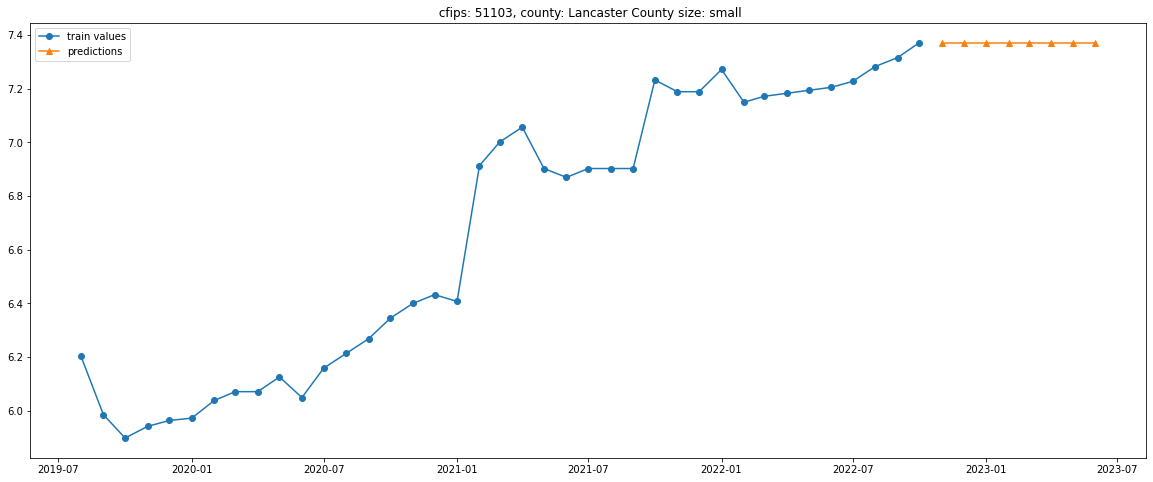

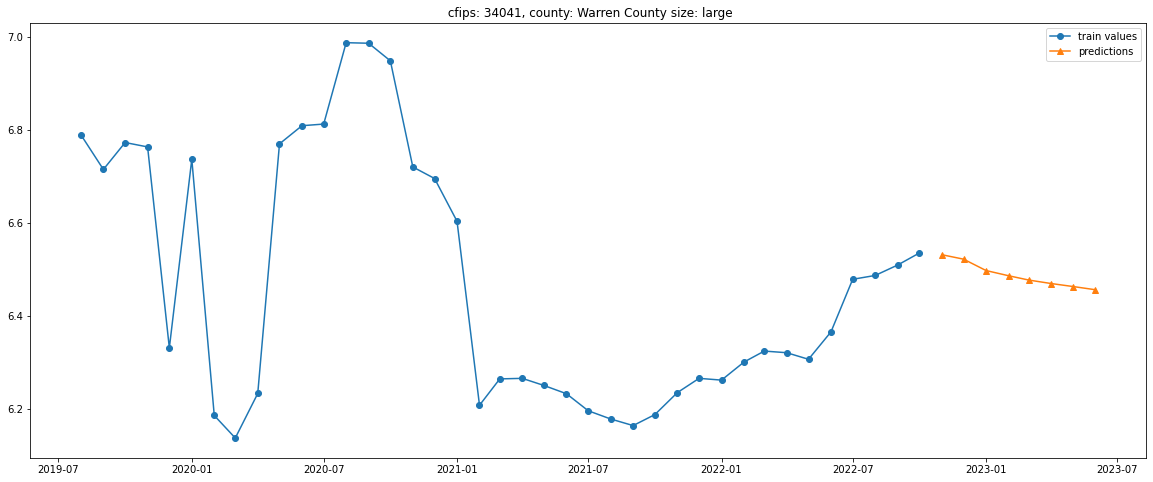

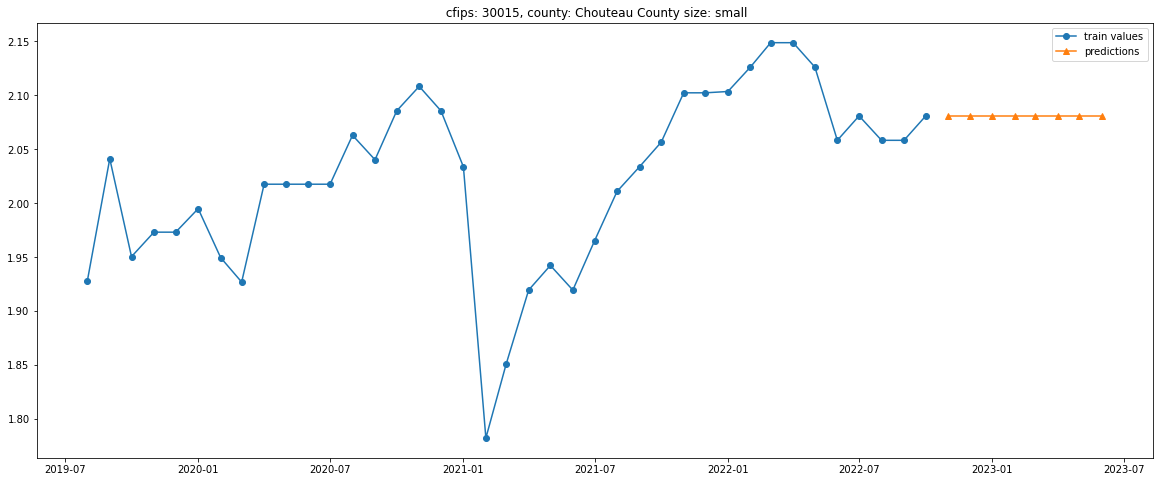

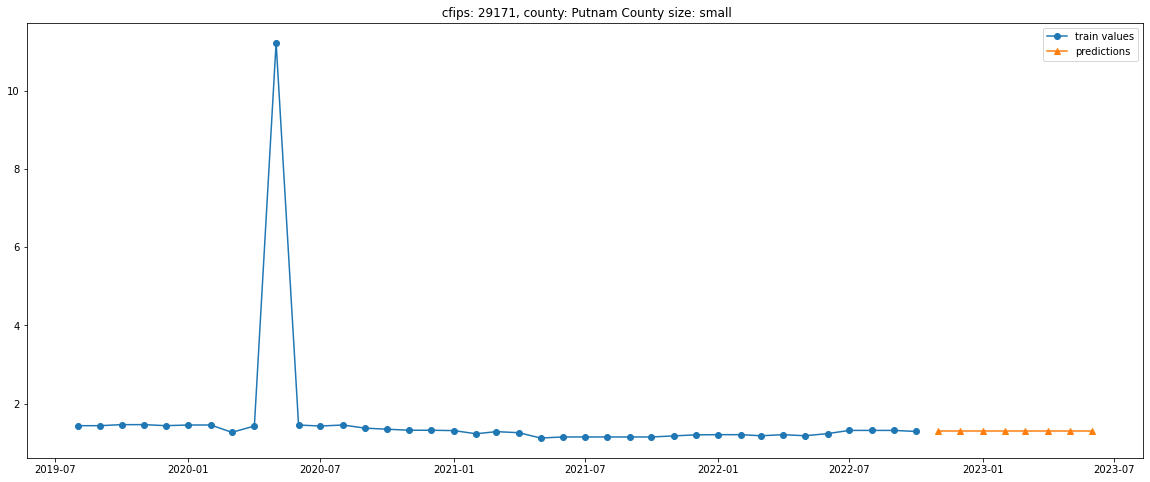

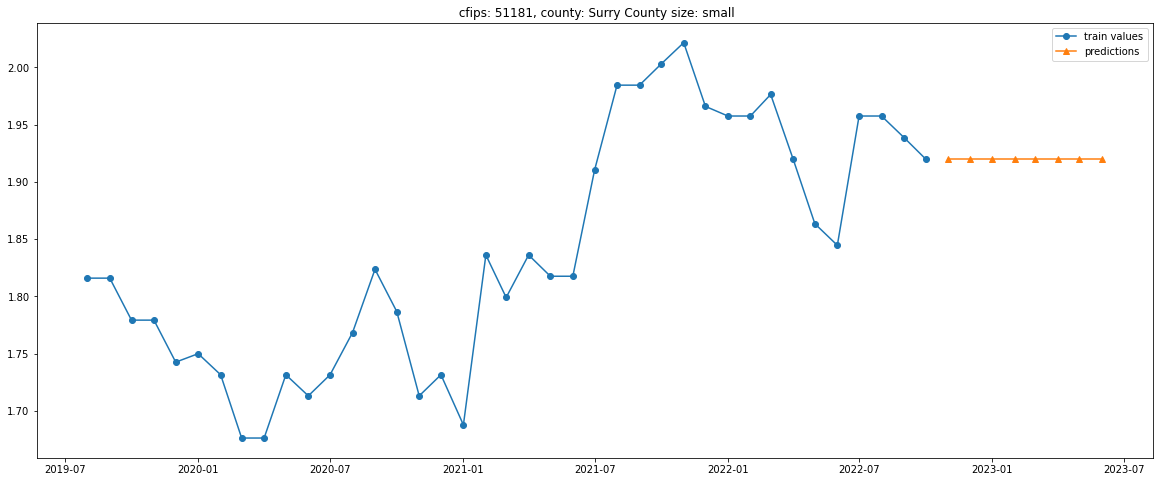

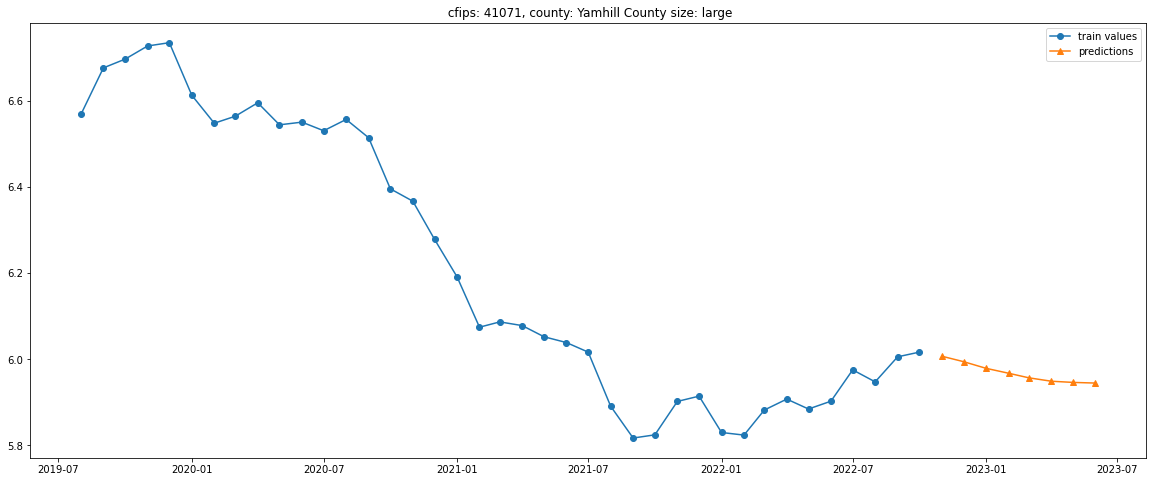

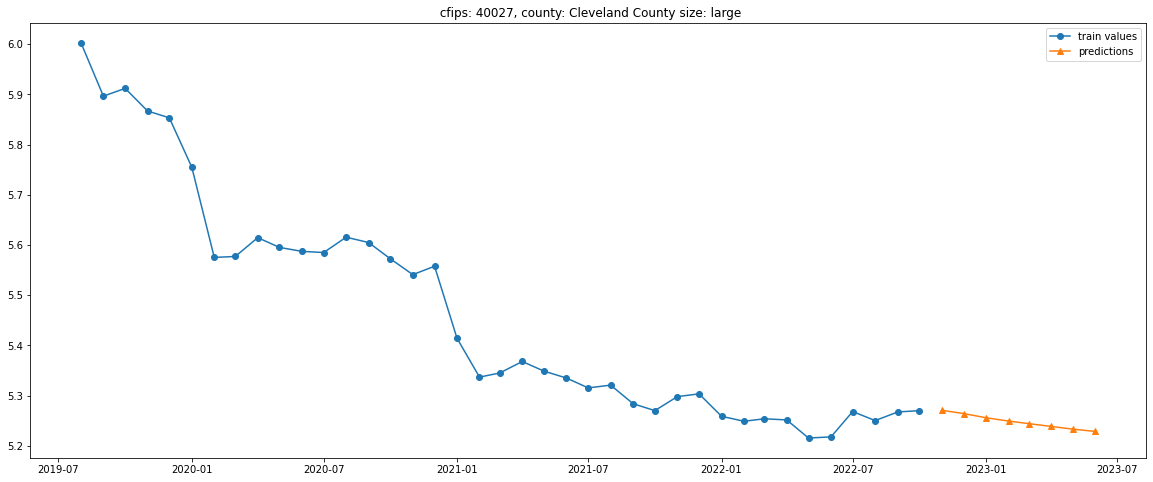

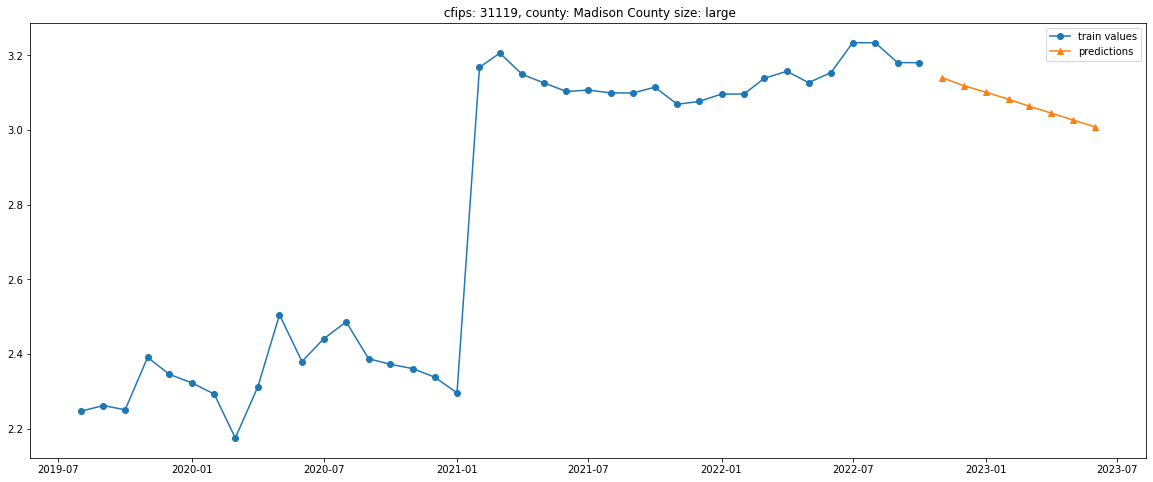

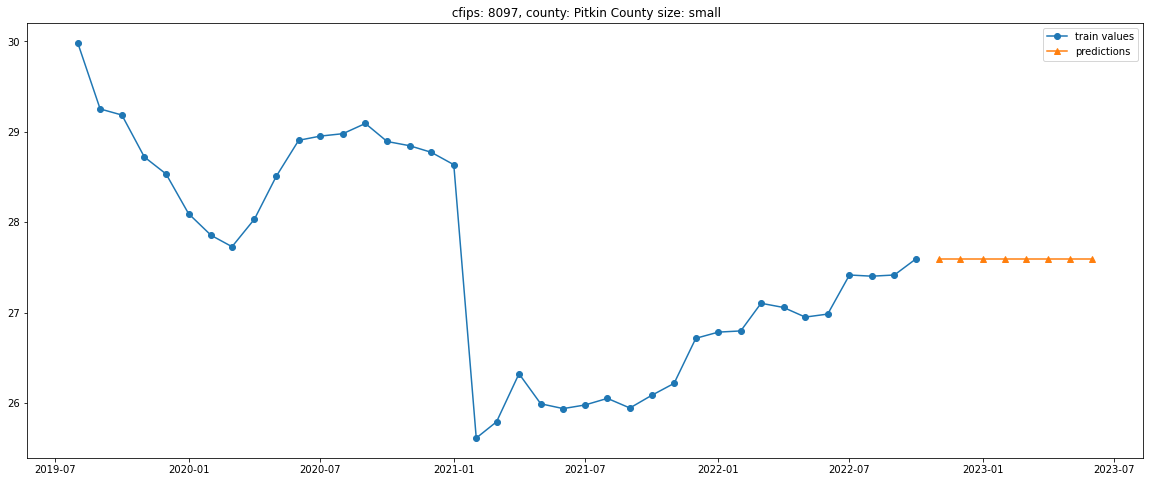

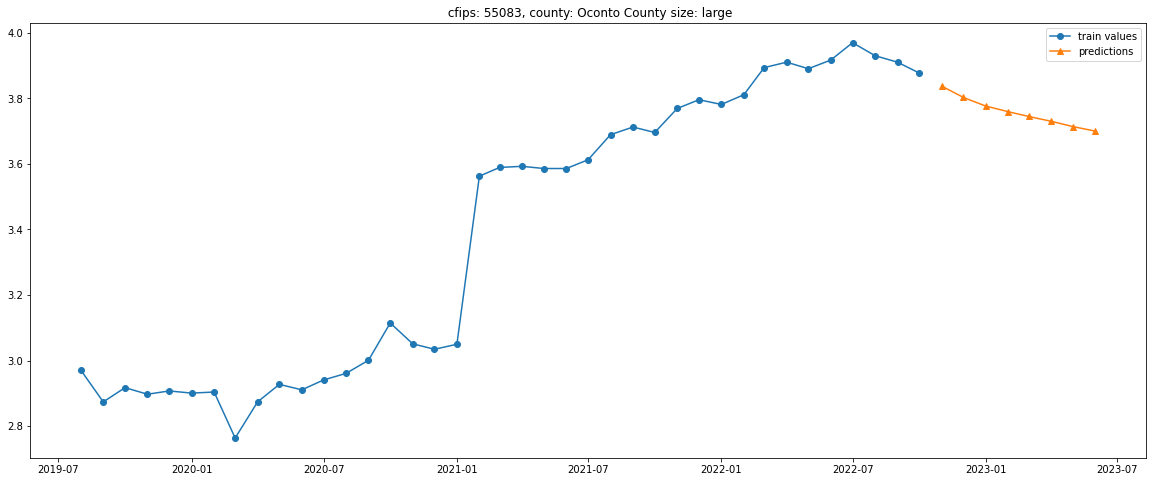

<IPython.core.display.Javascript object>

In [143]:
ids = test["cfips"].unique()
for i in range(10):
    c = np.random.choice(ids)
    plot_df = train[train["cfips"] == c].copy()
    test_plot = test[test["cfips"] == c].copy()
    plot_df["first_day_of_month"]= pd.to_datetime(plot_df["first_day_of_month"])
    plot_df["size"] = np.where(plot_df["cfips"].isin(cfips_largest_counties), "large", "small")
    test_plot["first_day_of_month"]= pd.to_datetime(test_plot["first_day_of_month"])
    last_target = plot_df["microbusiness_density"].values[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(
        plot_df["first_day_of_month"],
        plot_df["microbusiness_density"],
        "-o",
        label="train values",)
    plt.plot(
    test_plot["first_day_of_month"], test_plot["microbusiness_density"], "-^", label="predictions"
    )
    plt.title(f" cfips: {c}, county: {plot_df['county'].values[0]} size: {plot_df['size'].values[0]}")
    plt.legend()
    plt.show()